# 1. Introuction

This notebook outlines the creation, compilation, and training of multiple ViT networks using both transfer learning and regular learning of the whole backbone. Transfer learning allows leveraging pre-trained models to achieve high accuracy with reasonable training times by fine-tuning for the specific task at hand, in this case for food recognition. For the sake of fair comparison, the traning process of the models will be configured with the same number of epochs, learning rate, and regularization. The values of these parameters have been determined based of previous experimentation.

The following table summarize the models:

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 60 | 0.0001 | No | 85.9M |
| 2 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 60 | 0.0001 | No | 86.7M |
| 3 | Large | 16x16 | 24 | 1024 | 4096 | 16 | None | Yes | 60 | 0.0001 | No | 303.4M |
| 4 | Large | 16x16 | 24 | 1024 | 4096 | 16 | 1024 | Yes | 60 | 0.0001 | No | 304.5M |
| 5 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | No | 20 | 0.00001 | No | 85.9M |
| 6 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 20 | 0.00001 | No | 86.7M |
| 7 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |
| 8 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 10 | 0.0001 | CosineAnnealingLR | 86.7M |
| 9 | Base | 16x16 | 12 | 768 | 3072 | 12 | Multiple | No | 10 | 0.0001 | CosineAnnealingLR | 87.9M |
| 10 | Large | 16x16 | 24 | 1024 | 4096 | 16 | None | No | 10 | 0.00001 | No | 303.4M |

The transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets

# Import custom libraries
from helper_functions import create_dataloaders, set_seeds, display_random_images, save_model, load_model
from engine import train
from vision_transformer import ViT, ViTv2

# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_model': True,
    'save_model':  True,    
}

# Define target data directory
target_dir_name = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"
target_dir.mkdir(parents=True, exist_ok=True)

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

TRAIN = {
    'model_1': True, #ViT-Base -   no classification hidden units -       transfer learning -    No scheduling
    'model_2': True, #ViT-Base -   1024 classification hidden units -     transfer learning -    No scheduling
    'model_3': True, #ViT-Large -  no classification hidden units -       transfer learning -    No scheduling
    'model_4': True, #ViT-Large -  1024 classification hidden units -     transfer learning -    No scheduling
    'model_5': True, #ViT-Base -   no classification hidden units -       no transfer learning - No scheduling
    'model_6': True, #ViT-Base -   1024 classification hidden units -     no transfer learning - No scheduling
    'model_7': True, #ViT-Base -   no classification hidden units -       no transfer learning - CosineAnnealingLR
    'model_8': True, #ViT-Base -   1024 classification hidden units -     no transfer learning - CosineAnnealingLR
    'model_9': True, #ViT-Base -   multiple classification hidden units - no transfer learning - CosineAnnealingLR
    'model_10': True, #ViT-Large - no classification hidden units -       no transfer learning - No scheduling
}

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 3. Creating Dataloaders

In [3]:
# Default transformations for ViT-Base
pretrained_vitb_transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()
pretrained_vitb_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [4]:
# Default transformations for ViT-Large
pretrained_vitl_transforms = torchvision.models.ViT_L_16_Weights.DEFAULT.transforms()
pretrained_vitl_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
# Image size
IMG_SIZE = 224

# Manual transforms for the training dataset
manual_transforms = v2.Compose([           
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),    
])

# ViT-Base transforms

# Manual transforms for the training dataset
manual_transforms_aug_norm_train_vitb = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((256, 256)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test_vitb = v2.Compose([    
    v2.Resize((256, 256)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# ViT-Large transforms

# Manual transforms for the training dataset
manual_transforms_aug_norm_train_vitl = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((242, 242)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test_vitl = v2.Compose([    
    v2.Resize((242, 242)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

In [6]:
# Create data loaders for ViT-Base
train_dataloader_vitb, test_dataloader_vitb, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train_vitb,
    test_transform=manual_transforms_aug_norm_test_vitb,
    batch_size=BATCH_SIZE
)

# Get the pretrained ViT-Base weights
pretrained_vitb_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [6]:
# Create data loaders for ViT-Large
train_dataloader_vitl, test_dataloader_vitl, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train_vitl,
    test_transform=manual_transforms_aug_norm_test_vitl,
    batch_size=BATCH_SIZE
)

# Get the pretrained ViT-Large weights
pretrained_vitl_weights = torchvision.models.ViT_L_16_Weights.DEFAULT

# 4. Image Visualization

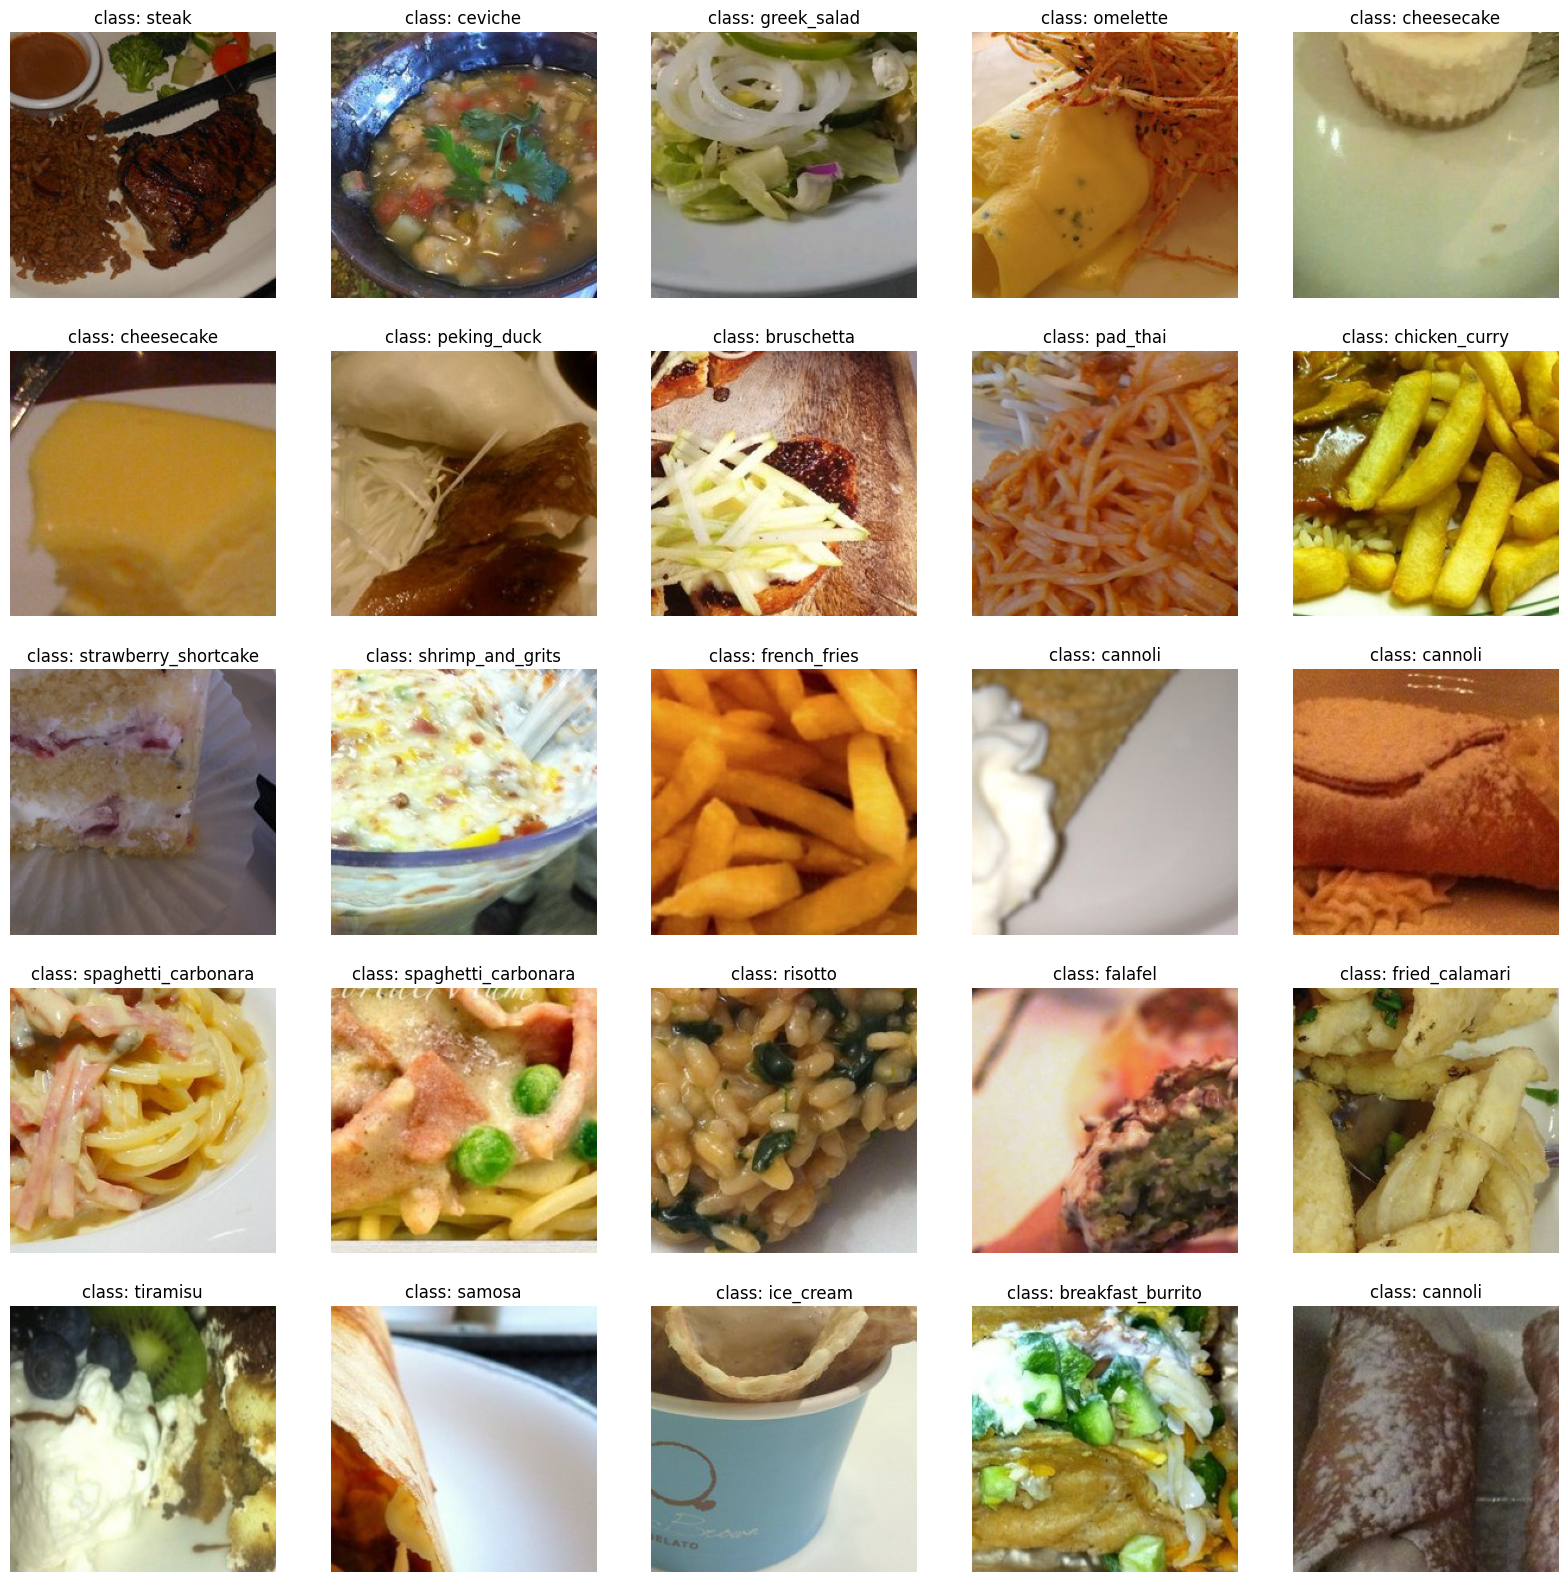

In [7]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Training

## 5.1. ViT-Base - No Hidden Layer Units


| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 60 | 0.0001 | No | 85.9M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_1']:
    vitbase16_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    vitbase16_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitbase16_model)

    # Print summary
    summary(vitbase16_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

In [ ]:
#if TRAIN['model_1']:
#    # Print summary of a pretrained model
#    summary(pretrained_vit,
#            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
#            col_names=["input_size", "output_size", "num_params", "trainable"],
#            col_width=20,
#            row_settings=["var_names"])

In [ ]:
#if TRAIN['model_1']:
#    # Check out that the parameters have been sucessfully copied
#    print("Weights of the pretrained model")
#    for name, param in pretrained_vit.named_parameters():
#        print(f"{name}: {param.data.mean()}")

#    print("...................")
#    print("Weights of the ViTBase model")
#    for name, param in vitbase16_model.named_parameters():
#        print(f"{name}: {param.data.mean()}")

The sizes of both models coincide and the copy operation looks correct.

Epoch: 60 | train_loss: 2.3214 | train_acc: 0.5764 | train_time: 2m46s | test_loss: 1.7269 | test_acc: 0.7442 | test_time: 2m5s | lr: 0.0001000000


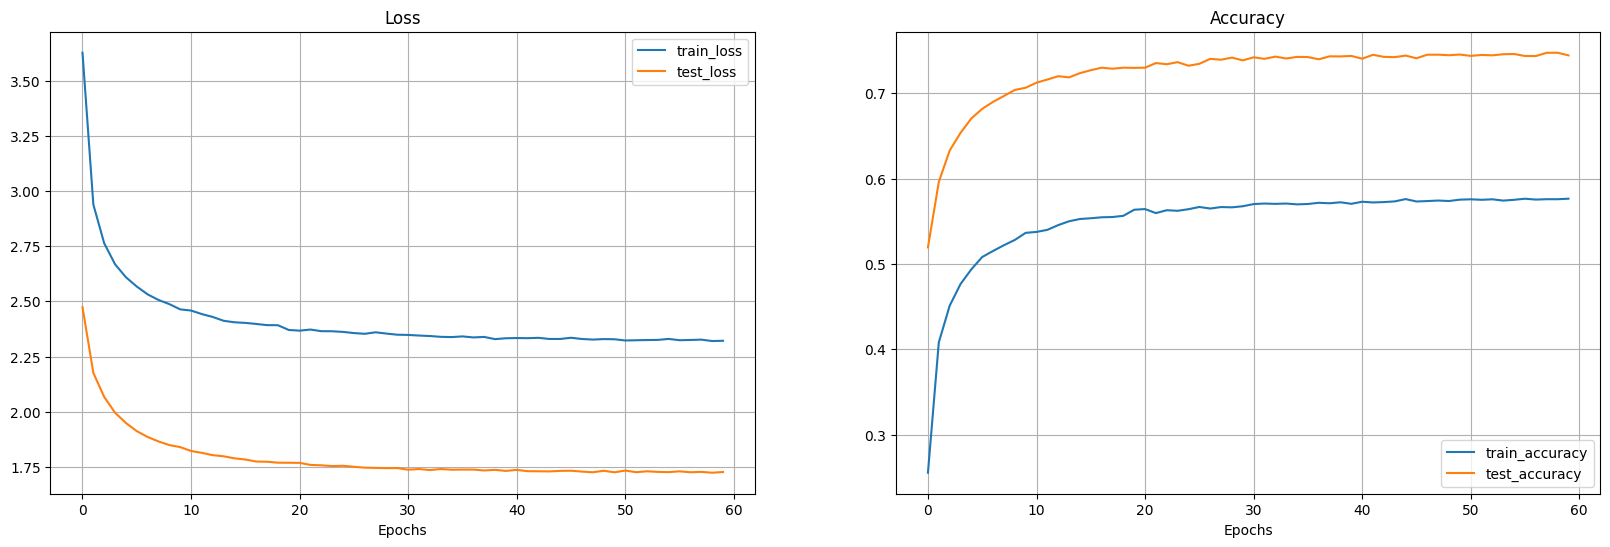

In [ ]:
# Train the model
if TRAIN['model_1']:
    model_type="vitbase16_1"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_model_name = model_name + ".pth"
    vitbase16_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_results = train(model=vitbase16_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [ ]:
# Save the model 
if TRAIN['model_1']:
    save_model(model=vitbase16_model,
                target_dir=model_dir,
                model_name=vitbase16_model_name)
    df_results = pd.DataFrame(vitbase16_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_1.pth


## 5.2. ViT-Base - 1024 Hidden Layer Units

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 2 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 60 | 0.0001 | No | 86.7M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_2']:
    vitbase16_2_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_2_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    vitbase16_2_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitbase16_2_model)

    # Print summary
    summary(vitbase16_2_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 60 | train_loss: 2.0116 | train_acc: 0.6571 | train_time: 2m39s | test_loss: 1.6461 | test_acc: 0.7609 | test_time: 2m2s | lr: 0.0001000000


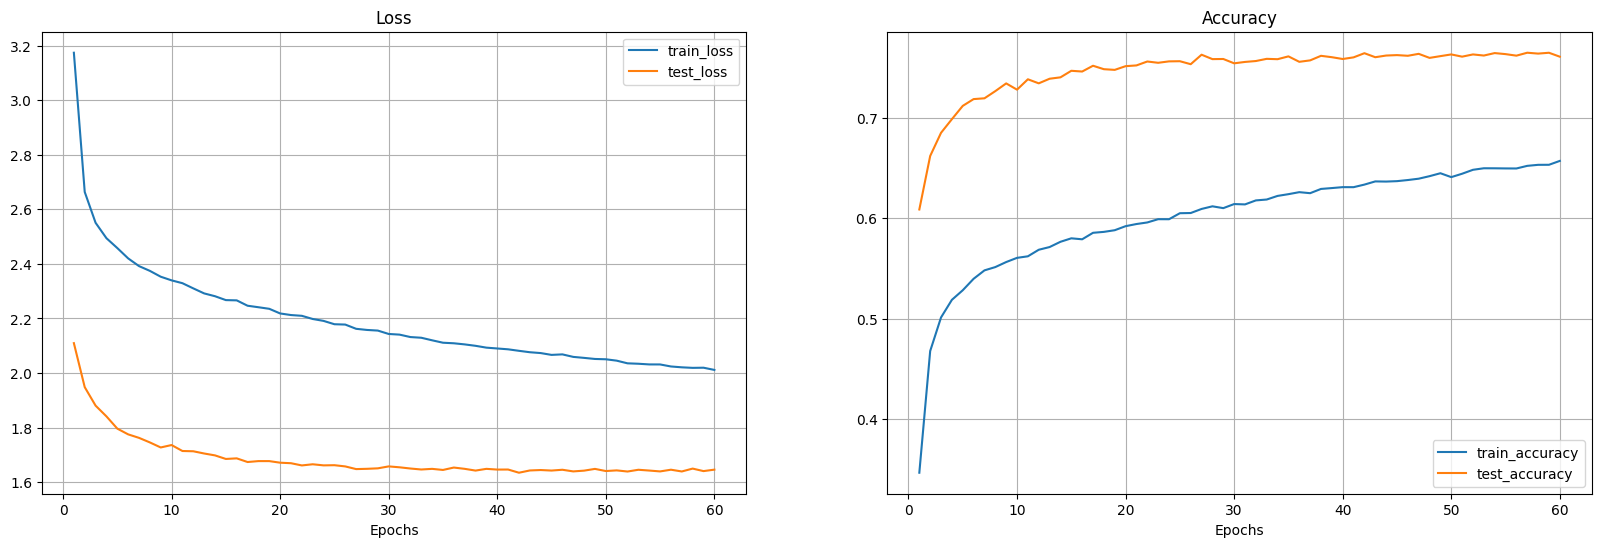

In [ ]:
# Train the model
if TRAIN['model_2']:
    model_type="vitbase16_2"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_2_model_name = model_name + ".pth"
    vitbase16_2_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_2_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_2_results = train(model=vitbase16_2_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [ ]:
# Save the model 
if TRAIN['model_2']:
    save_model(model=vitbase16_2_model,
                target_dir=model_dir,
                model_name=vitbase16_2_model_name)
    df_results = pd.DataFrame(vitbase16_2_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_2_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_2.pth


## 5.3. ViT-Large - No Hidden Layer Units

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 3 | Large | 16x16 | 24 | 1024 | 4096 | 16 | None | Yes | 60 | 0.0001 | No | 303.4M |

In [ ]:
# Create the ViT-Large model
if TRAIN['model_3']:
    vitlarge16_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=24,
        emb_dim=1024,
        mlp_size=4096,
        num_heads=16,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
    vitlarge16_model.copy_weights(pretrained_vitl_weights)

    # And freeze the backbone except the classification head params
    vitlarge16_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitlarge16_model)

    # Print summary
    summary(vitlarge16_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

In [ ]:
# Print summary of a pretrained model
#if TRAIN['model_3']:
#    summary(pretrained_vit,
#        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

In [ ]:
# Check out that the parameters have been sucessfully copied
#if TRAIN['model_3']:
#    print("Weights of the pretrained model")
#    for name, param in pretrained_vit.named_parameters():
#        print(f"{name}: {param.data.mean()}")

#    print("...................")
#    print("Weights of the ViTBase model")
#    for name, param in vitlarge16_model.named_parameters():
#        print(f"{name}: {param.data.mean()}")

Epoch: 60 | train_loss: 1.7480 | train_acc: 0.7467 | train_time: 5m46s | test_loss: 1.6416 | test_acc: 0.7725 | test_time: 4m58s | lr: 0.0001000000


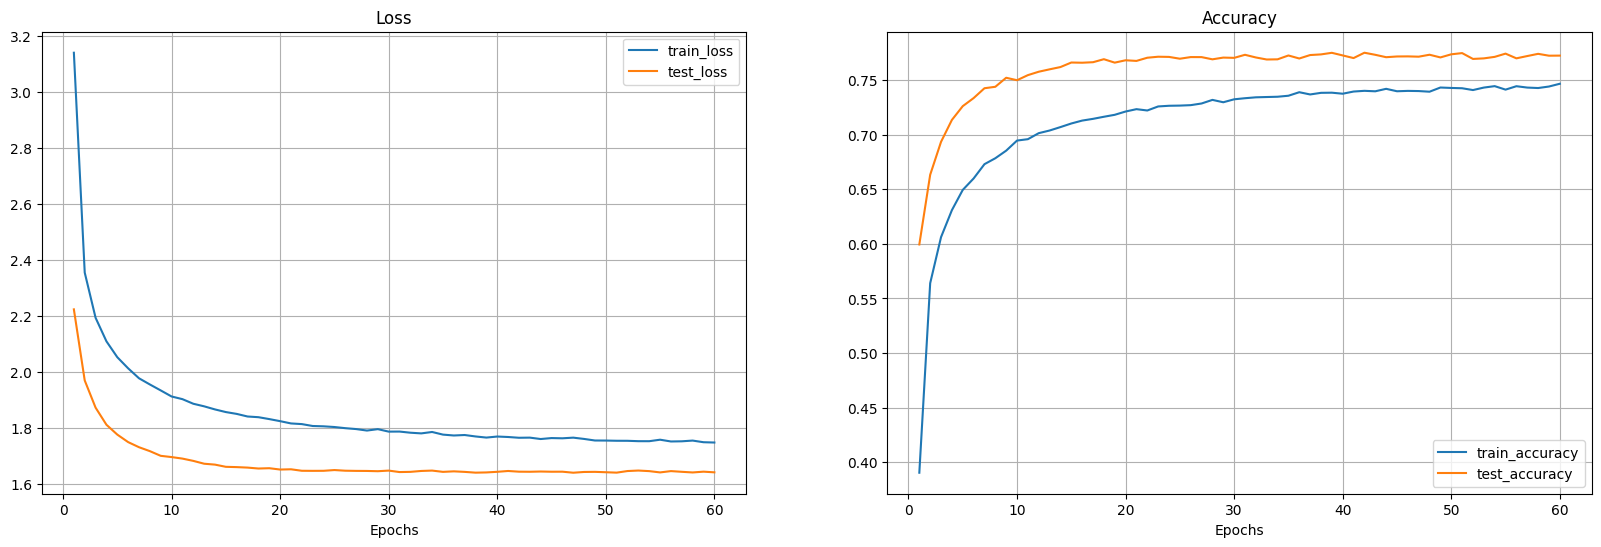

In [ ]:
# Train the model
if TRAIN['model_3']:
    model_type="vitlarge16_1"
    EPOCHS = 60
    LR = 0.0001
    model_name = f"{model_type}"
    vitlarge16_model_name = model_name + ".pth"
    vitlarge16_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitlarge16_results = train(model=vitlarge16_model, 
                            train_dataloader=train_dataloader_vitl,
                            test_dataloader=test_dataloader_vitl,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [ ]:
# Save the model
if TRAIN['model_3']: 
    save_model(model=vitlarge16_model,
                target_dir=model_dir,
                model_name=vitlarge16_model_name)
    df_results = pd.DataFrame(vitlarge16_results)
    df_results.to_csv(os.path.join(model_dir, vitlarge16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_1.pth


# 5.4. ViT-Large - 1024 Hidden Layer Units

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 4 | Large | 16x16 | 24 | 1024 | 4096 | 16 | 1024 | Yes | 20 | 0.0001 | No | 304.5M |

In [ ]:
# Create the ViT-Large model
if TRAIN['model_4']:
    vitlarge16_2_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=24,
        emb_dim=1024,
        mlp_size=4096,
        num_heads=16,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
    vitlarge16_2_model.copy_weights(pretrained_vitl_weights)

    # And freeze the backbone except the classification head params
    vitlarge16_2_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitlarge16_2_model)

    # Print sumary
    summary(vitlarge16_2_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

In [ ]:
# Print summary of a pretrained model
#if TRAIN['model_4']:
#    summary(pretrained_vit,
#            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
#            col_names=["input_size", "output_size", "num_params", "trainable"],
#            col_width=20,
#            row_settings=["var_names"])

In [ ]:
# Check out that the parameters have been sucessfully copied
#if TRAIN['model_4']:
#    print("Weights of the pretrained model")
#    for name, param in pretrained_vit.named_parameters():
#        print(f"{name}: {param.data.mean()}")

#    print("...................")
#    print("Weights of the ViTBase model")
#    for name, param in vitlarge16_2_model.named_parameters():
#        print(f"{name}: {param.data.mean()}")

Epoch: 20 | train_loss: 1.5839 | train_acc: 0.7868 | train_time: 5m48s | test_loss: 1.5705 | test_acc: 0.7811 | test_time: 4m59s | lr: 0.0001000000


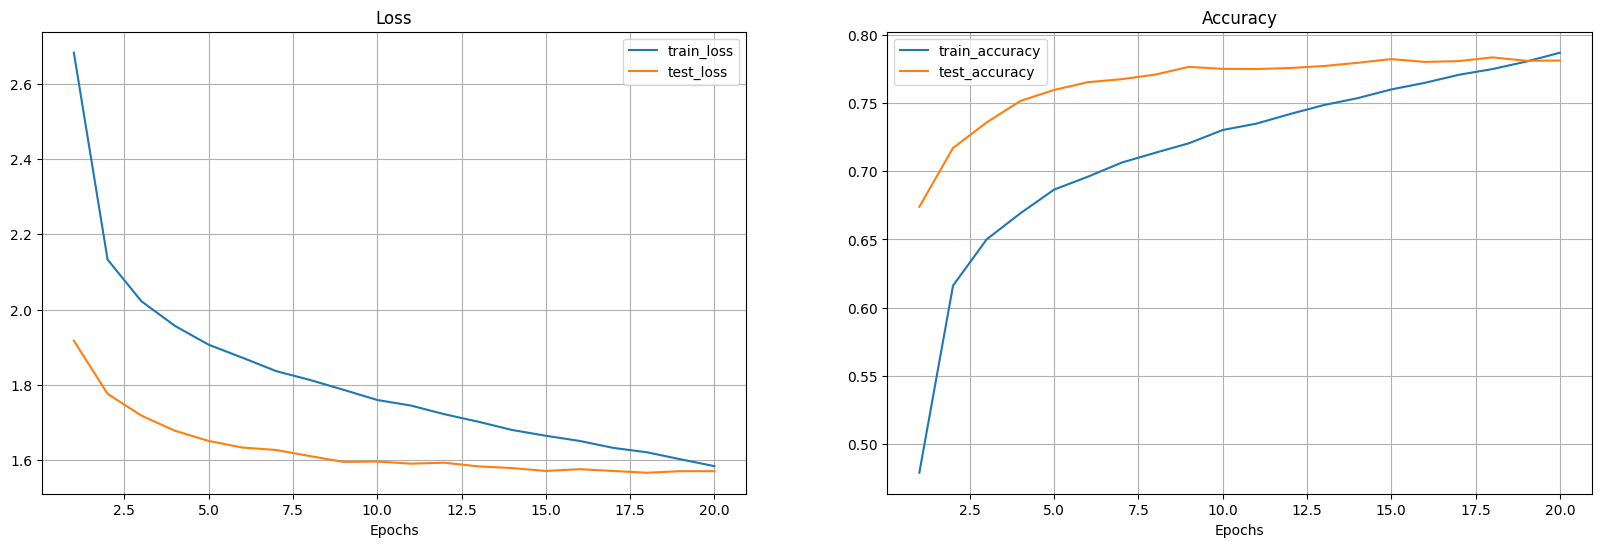

In [ ]:
# Train the model
if TRAIN['model_4']:
    model_type="vitlarge16_2"
    EPOCHS = 20
    LR = 0.0001
    model_name = f"{model_type}"
    vitlarge16_2_model_name = model_name + ".pth"
    vitlarge16_2_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_2_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitlarge16_2_results = train(model=vitlarge16_2_model, 
                                train_dataloader=train_dataloader_vitl,
                                test_dataloader=test_dataloader_vitl,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=None,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [ ]:
# Save the model
if TRAIN['model_4']:
    save_model(model=vitlarge16_2_model,
                target_dir=model_dir,
                model_name=vitlarge16_2_model_name)
    df_results = pd.DataFrame(vitlarge16_2_results)
    df_results.to_csv(os.path.join(model_dir, vitlarge16_2_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_2.pth


# 5.5. ViT-Base - No Hidden Layer Units - No Transfer Learning

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 5 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | No | 20 | 0.00001 | No | 85.9M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_5']:
    vitbase16_3_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        #classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_3_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    #vitbase16_2_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitbase16_3_model)

    # Print summary
    summary(vitbase16_3_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 20 | train_loss: 1.1955 | train_acc: 0.8853 | train_time: 5m54s | test_loss: 1.2310 | test_acc: 0.8680 | test_time: 2m7s | lr: 0.0000100000


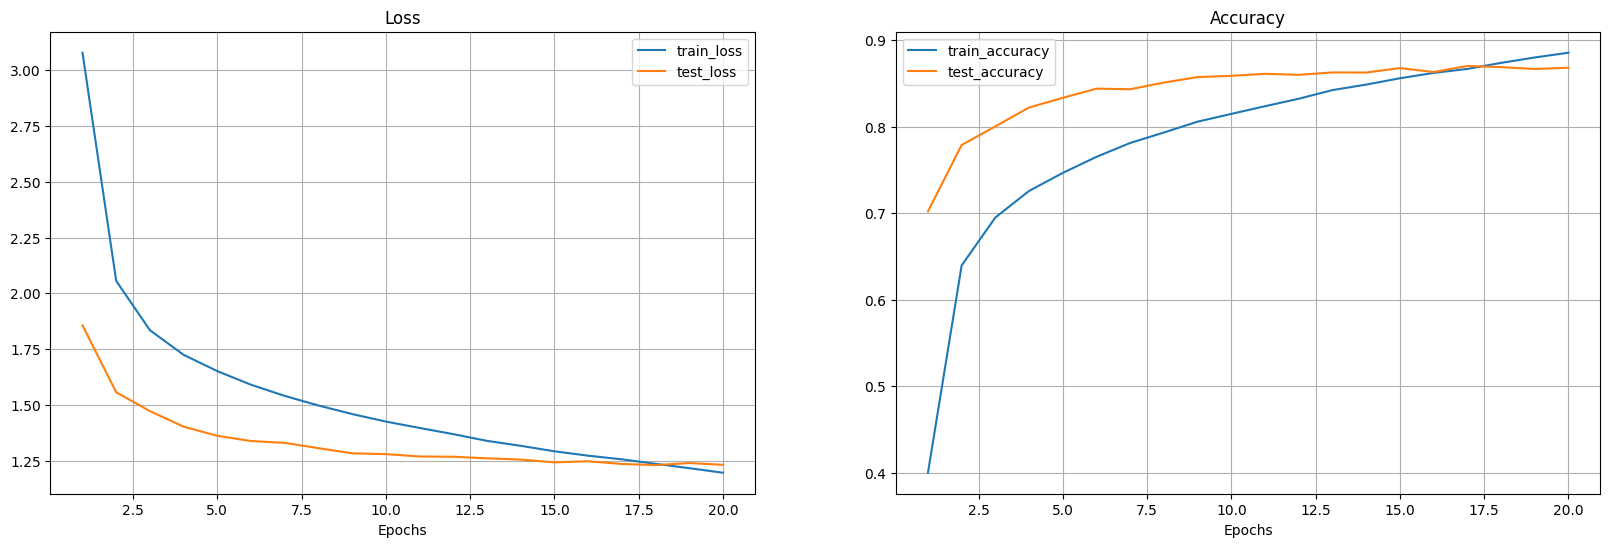

In [12]:
# Train the model
if TRAIN['model_5']:
    model_type="vitbase16_3"
    EPOCHS = 20
    LR = 0.00001
    model_name = f"{model_type}"
    vitbase16_3_model_name = model_name + ".pth"
    vitbase16_3_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_3_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_3_results = train(model=vitbase16_3_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [13]:
# Save the model 
if TRAIN['model_5']:
    save_model(model=vitbase16_3_model,
                target_dir=model_dir,
                model_name=vitbase16_3_model_name)
    df_results = pd.DataFrame(vitbase16_3_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_3_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_3.pth


# 5.6. ViT-Base - 1024 Hidden Layer Units - No Transfer Learning

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 6 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 20 | 0.00001 | No | 86.7M |

In [ ]:
# Create the ViT-Base model
if TRAIN['model_6']:
    vitbase16_4_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_4_model.copy_weights(pretrained_vitb_weights)

    # And freeze the backbone except the classification head params
    #vitbase16_2_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitbase16_4_model)

    # Print summary
    summary(vitbase16_4_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 20 | train_loss: 1.1982 | train_acc: 0.8813 | train_time: 5m57s | test_loss: 1.2205 | test_acc: 0.8673 | test_time: 2m4s | lr: 0.0000100000


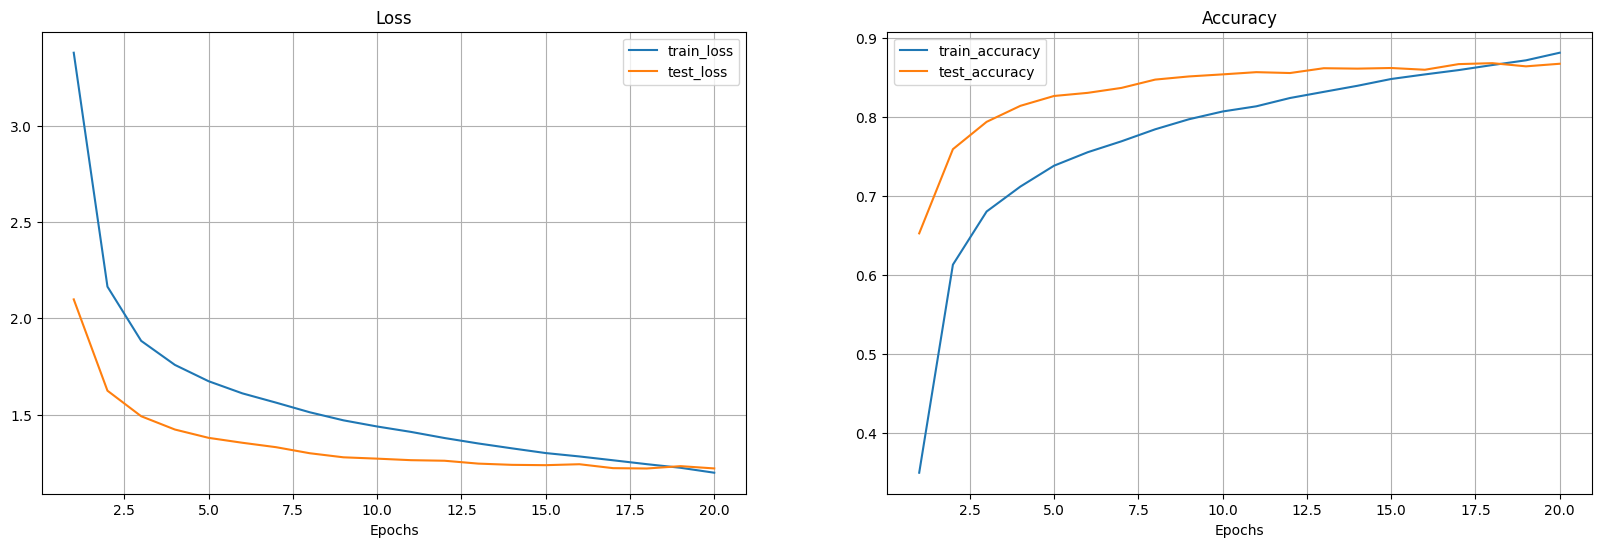

In [15]:
# Train the model
if TRAIN['model_6']:
    model_type="vitbase16_4"
    EPOCHS = 20
    LR = 0.00001
    model_name = f"{model_type}"
    vitbase16_4_model_name = model_name + ".pth"
    vitbase16_4_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_4_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_4_results = train(model=vitbase16_4_model, 
                            train_dataloader=train_dataloader_vitb,
                            test_dataloader=test_dataloader_vitb,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            amp=True,
                            writer=None)

In [16]:
# Save the model 
if TRAIN['model_6']:
    save_model(model=vitbase16_4_model,
                target_dir=model_dir,
                model_name=vitbase16_4_model_name)
    df_results = pd.DataFrame(vitbase16_4_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_4_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_4.pth


# 5.7. ViT-Base - No Hidden Layer Units - No Transfer Learning - CosineAnnealingLR

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 7 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |

In [8]:
# Create the ViT-Base model
if TRAIN['model_7']:
    vitbase16_5_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        #classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_5_model.copy_weights(pretrained_vitb_weights)

    # Compile model
    torch.compile(vitbase16_5_model)

    # Print summary
    summary(vitbase16_5_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 10 | train_loss: 1.0248 | train_acc: 0.9387 | fpr_at_recall: 0.0011 | train_time: 5m57s | test_loss: 1.1934 | test_acc: 0.8774 | fpr_at_recall: 0.0082 | test_time: 2m4s | lr: 0.0000034227


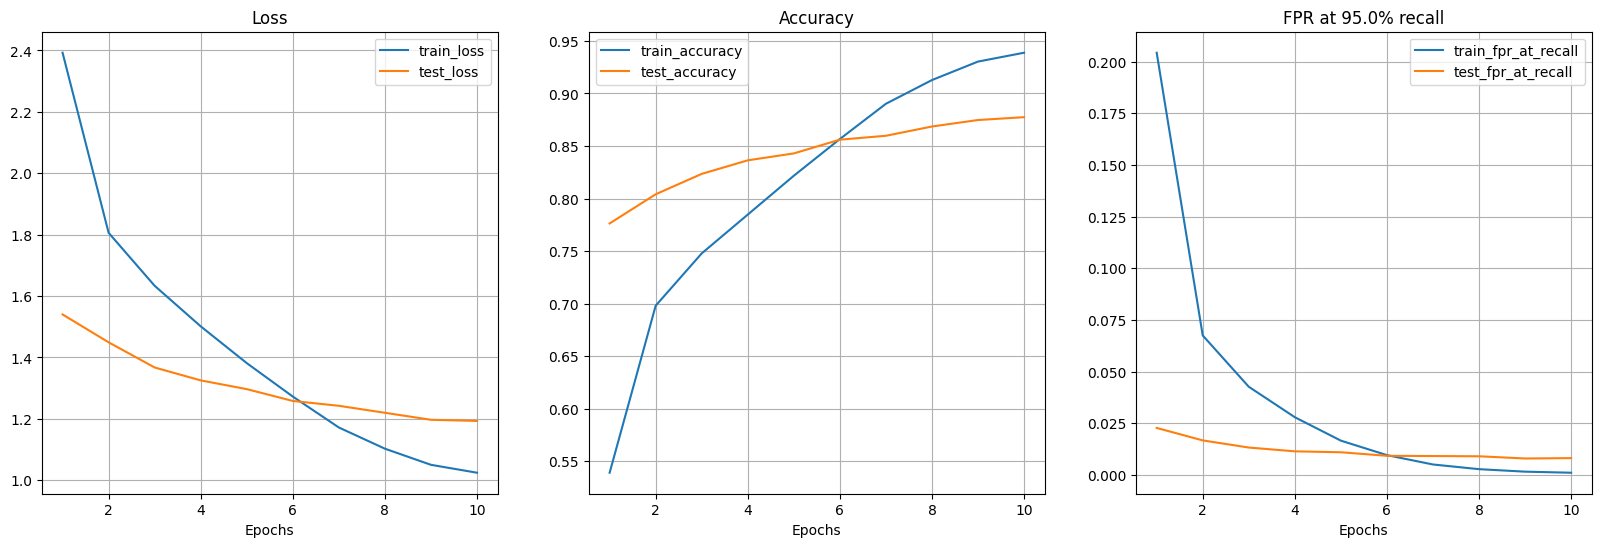

In [9]:
# Train the model
if TRAIN['model_7']:
    model_type="vitbase16_5"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_5_model_name = model_name + ".pth"
    vitbase16_5_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_5_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_5_results = train(model=vitbase16_5_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [10]:
# Save the model 
if TRAIN['model_7']:
    save_model(model=vitbase16_5_model,
                target_dir=model_dir,
                model_name=vitbase16_5_model_name)
    df_results = pd.DataFrame(vitbase16_5_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_5_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_5.pth


In [14]:
pd.DataFrame(vitbase16_5_results)

train_loss  train_acc  test_loss  test_acc  train_time [s]  test_time [s]  \
0    2.392436   0.539143   1.540182  0.776298      367.317250     126.852905   
1    1.805976   0.698041   1.449407  0.804039      359.815828     124.753922   
2    1.633431   0.747798   1.367424  0.823441      358.259442     124.968192   
3    1.501464   0.784727   1.325448  0.836341      356.847662     124.467907   
4    1.381690   0.821678   1.296990  0.842924      356.230547     124.493843   
5    1.272768   0.856602   1.258474  0.855987      357.374070     124.140858   
6    1.172050   0.890153   1.242700  0.859705      356.925927     124.346208   
7    1.103026   0.912707   1.219964  0.868522      357.090943     124.666674   
8    1.050525   0.930290   1.197134  0.874693      358.261302     129.569437   
9    1.024775   0.938709   1.193399  0.877392      357.886866     124.631993   

         lr  train_fpr_at_recall  test_fpr_at_recall  
0  0.000100             0.204308            0.022782  
1  0.000098             0.067518            0.016745  
2  0.000091             0.042699            0.013290  
3  0.000080             0.027963            0.011461  
4  0.000066             0.016625            0.011010  
5  0.000051             0.009619            0.009296  
6  0.000035             0.005096            0.009183  
7  0.000021             0.002831            0.009065  
8  0.000010             0.001623            0.007999  
9  0.000003             0.001110            0.008174

# 5.8. ViT-Base - 1024 Hidden Layer Units - No Transfer Learning - CosineAnnealingLR

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 8 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 10 | 0.0001 | CosineAnnealingLR | 86.7M |

In [11]:
# Create the ViT-Base model
if TRAIN['model_8']:
    vitbase16_6_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_head_hidden_units=1024, # Add a hidder layer of 1024 neurons to the classification head
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_6_model.copy_weights(pretrained_vitb_weights)

    # Compile model
    torch.compile(vitbase16_6_model)

    # Print summary
    summary(vitbase16_6_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

Epoch: 10 | train_loss: 1.0396 | train_acc: 0.9309 | fpr_at_recall: 0.0017 | train_time: 5m56s | test_loss: 1.1912 | test_acc: 0.8737 | fpr_at_recall: 0.0086 | test_time: 2m4s | lr: 0.0000034227


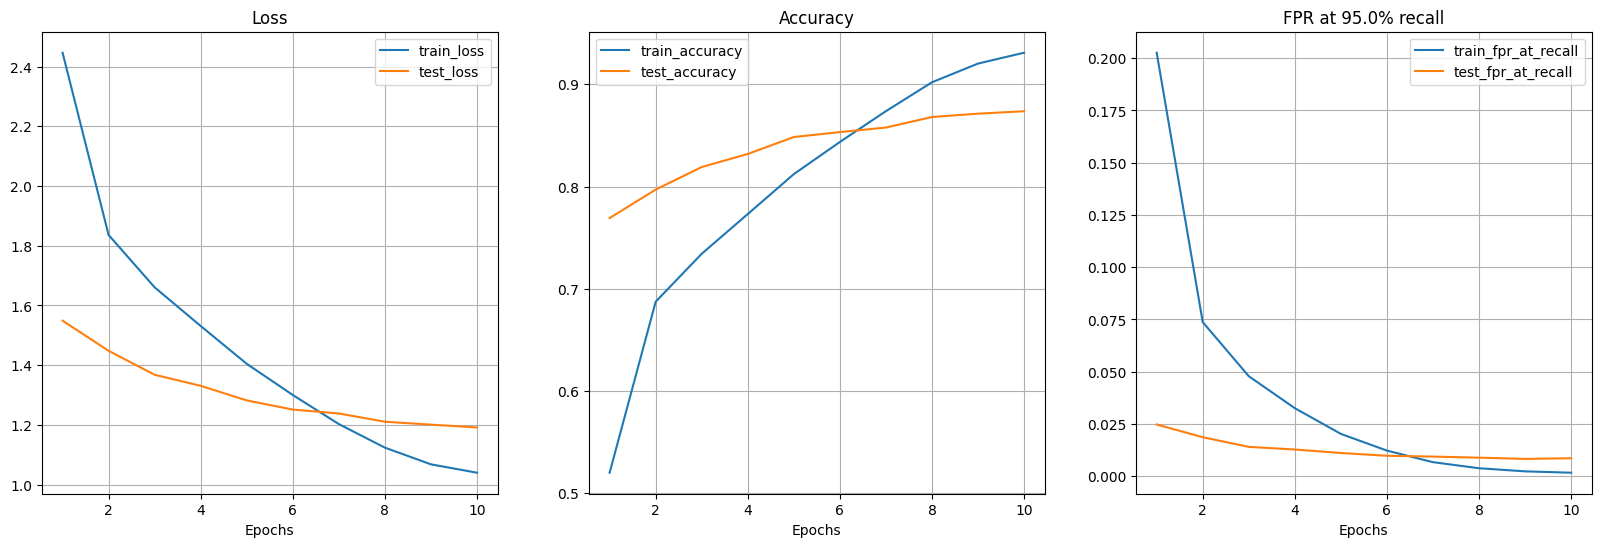

In [12]:
# Train the model
if TRAIN['model_8']:
    model_type="vitbase16_6"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_6_model_name = model_name + ".pth"
    vitbase16_6_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_6_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_6_results = train(model=vitbase16_6_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [13]:
# Save the model 
if TRAIN['model_8']:
    save_model(model=vitbase16_6_model,
                target_dir=model_dir,
                model_name=vitbase16_6_model_name)
    df_results = pd.DataFrame(vitbase16_6_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_6_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_6.pth


# 5.9. ViT-Base - Multiple Classification Heads - No Transfer Learning - CosineAnnealingLR

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 9 | Base | 16x16 | 12 | 768 | 3072 | 12 | Multiple | No | 10 | 0.0001 | CosineAnnealingLR | 87.9M |

In [8]:
# Create the ViT-Base model
if TRAIN['model_9']:

    # Create independent classifications heads with different numbers of hidden unit neurons
    head1 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=1024),
        nn.GELU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=1024, out_features=len(class_names))
        )
    
    head2 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=768),
        nn.GELU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=768, out_features=len(class_names))
    )

    head3 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=512),
        nn.GELU(),
        nn.Dropout(p=0.1),
        nn.Linear(in_features=512, out_features=len(class_names))
    )

    head4 = nn.Sequential(
        nn.LayerNorm(normalized_shape=768),
        nn.Linear(in_features=768, out_features=len(class_names))
    )

    vitbase16_7_model = ViTv2(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=12,
        emb_dim=768,
        mlp_size=3072,
        num_heads=12,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        classif_heads=[head1, head2, head3, head4],
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
    vitbase16_7_model.copy_weights(pretrained_vitb_weights)

    # Compile model
    torch.compile(vitbase16_7_model)

In [9]:
# Print summary
summary(vitbase16_7_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViTv2 (ViTv2)                                                [64, 3, 224, 224]    [64, 101]            --                   True
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              True
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
├─Sequential (encoder)                                       [64, 197, 768]       [64, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [64, 197, 768]       [64, 197, 768]

Epoch: 10 | train_loss: 1.0296 | train_acc: 0.9317 | fpr_at_recall: 0.0015 | train_time: 6m8s | test_loss: 1.1867 | test_acc: 0.8752 | fpr_at_recall: 0.0083 | test_time: 2m7s | lr: 0.0000034227


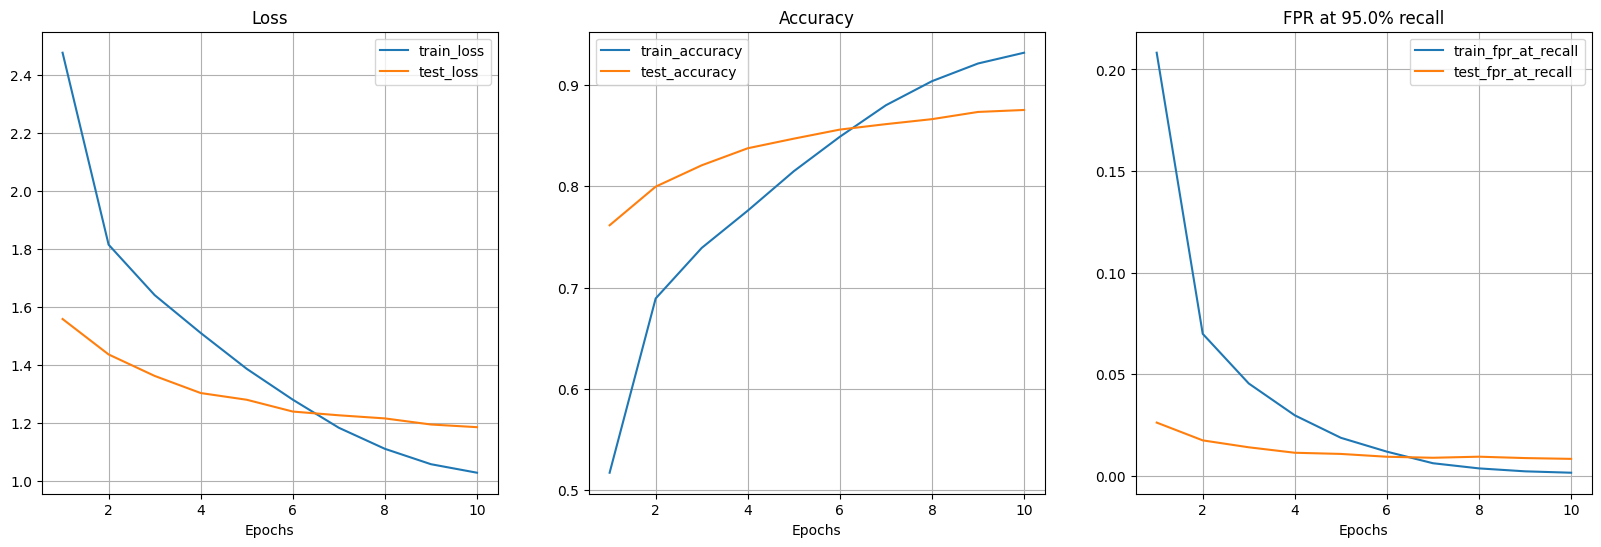

In [10]:
# Train the model
if TRAIN['model_9']:
    model_type="vitbase16_7"
    EPOCHS = 10
    LR = 0.0001
    model_name = f"{model_type}"
    vitbase16_7_model_name = model_name + ".pth"
    vitbase16_7_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_7_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitbase16_7_results = train(model=vitbase16_7_model, 
                                train_dataloader=train_dataloader_vitb,
                                test_dataloader=test_dataloader_vitb,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                recall_threshold=0.95,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [11]:
# Save the model 
if TRAIN['model_9']:
    save_model(model=vitbase16_7_model,
                target_dir=model_dir,
                model_name=vitbase16_7_model_name)
    df_results = pd.DataFrame(vitbase16_7_results)
    df_results.to_csv(os.path.join(model_dir, vitbase16_7_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_7.pth


# 5.7. ViT-Large - No Hidden Layer Units - No Transfer Learning

In [ ]:
# Create the ViT-Large model
if TRAIN['model_10']:
    vitlarge16_3_model = ViT(
        img_size=IMG_SIZE,
        in_channels=3,
        patch_size=16,
        num_transformer_layers=24,
        emb_dim=1024,
        mlp_size=4096,
        num_heads=16,
        attn_dropout=0,
        mlp_dropout=0.1,
        emb_dropout=0.1,
        num_classes=len(class_names)
    )

    # Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
    vitlarge16_3_model.copy_weights(pretrained_vitl_weights)

    # And freeze the backbone except the classification head params
    #vitlarge16_model.set_params_frozen(except_head=True)

    # Compile model
    torch.compile(vitlarge16_3_model)

    # Print summary
    summary(vitlarge16_3_model,
            input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"])

NameError: name 'pretrained_vitl_weights' is not defined

In [ ]:
# Train the model
if TRAIN['model_10']:
    model_type="vitlarge16_3"
    EPOCHS = 20
    LR = 0.00001
    model_name = f"{model_type}"
    vitlarge16_3_model_name = model_name + ".pth"
    vitlarge16_3_results_df = model_name + ".csv"

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_3_model.parameters(),
                                    lr=LR,
                                    betas=(0.9, 0.999),
                                    weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # And train...
    vitlarge16_3_results = train(model=vitlarge16_3_model, 
                                 train_dataloader=train_dataloader_vitl,
                                 test_dataloader=test_dataloader_vitl,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 scheduler=None,
                                 epochs=EPOCHS,
                                 device=device,
                                 plot_curves=True,
                                 amp=True,
                                 writer=None)

Training epoch 1...


  0%|          | 0/1579 [00:00<?, ?it/s]

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


The training time for the ViT-Large architecture withtout transfer learning cannot be afforded with a NVIDIA GeFoce RTX4070 GPU

In [ ]:
# Save the model 
if TRAIN['model_10']:
    save_model(model=vitlarge16_3_model,
                target_dir=model_dir,
                model_name=vitlarge16_3_model_name)
    df_results = pd.DataFrame(vitlarge16_3_results)
    df_results.to_csv(os.path.join(model_dir, vitlarge16_3_results_df), index=False)  